## Setup stuff 

Just some setup stuff to generate a sample dataset.  Feel free to jump ahead.


```bash
download_chandra_obsid 7901 --exclude vvref,osol,eph1 --quiet

chandra_repro 7901 out=7901/repro clob+ verb=0

fluximage 7901/repro/acisf07901_repro_evt2.fits"[ccd_id=7]" \
  7901/fi/out bin=1 band=broad mode=h clob+ verb=0
```

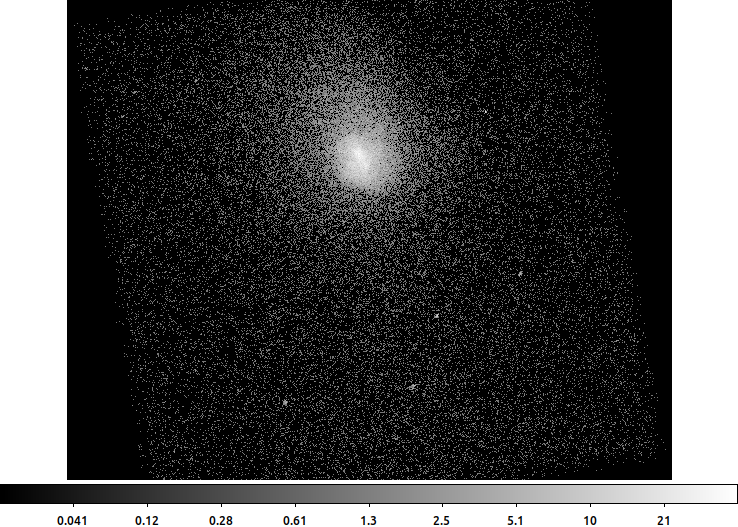

In [1]:
ds9 7901/fi/out_broad_thresh.img -block to 2 -scale log \
  -saveimage png ds9_01.png -exit

display < ds9_01.png

## Generate regions

Obviously however you want to make regions is fine.

I'm just going to use `dmellipse` to generate circle that enclude from 5% to 95% of the total counts.

In [2]:
dmcopy 7901/fi/out_broad_thresh.img"[sky=circle(4142,3980,200)]" 7901/img.fits clob+

In [3]:
dmellipse 7901/img.fits 7901/ellipse.reg fraction="lgrid(0.05:0.96:0.05)" \
  fix_ellip=yes fix_cen=yes ellip=1 step=50 mode=h clob+

> Note: `lgrid` is stack syntax for _linear grid_.  I need to add a little bit to the last number to get 0.95 included which is where the `0.96` comes from.

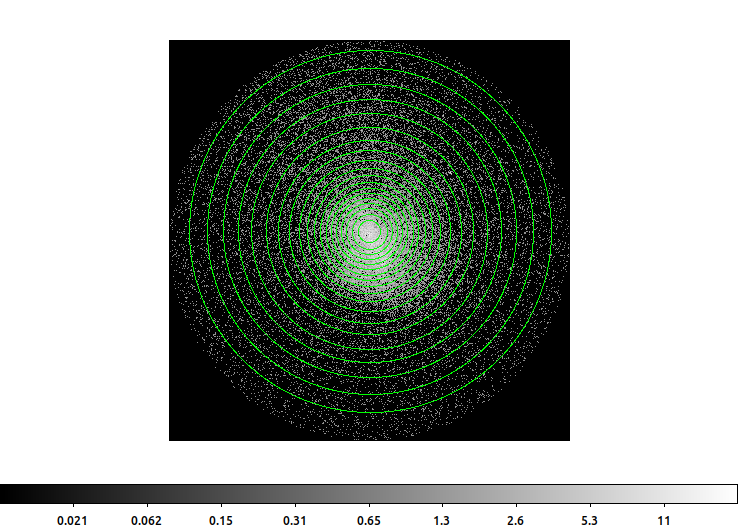

In [4]:
ds9 7901/img.fits -log -region 7901/ellipse.reg \
  -saveimage png ds9_02.png -quit 

display < ds9_02.png

## Magic happens

Not really.

The idea here is to make a map where each pixel in the map, maps to each of the individual annulli. 

In my adative binning bag-of-tricks, I have a script that does this: `mkregmap`.

If you want to play with `mkregmap`


### `conda`

```bash
$ conda activate ciao
$ conda install -c https://cxc.cfa.harvard.edu/conda/ciao \
    -c https://hea-www.harvard.edu/~kjg/ciao adaptivebin
```

### `ciao-install`

```bash
$ ciao
$ git clone https://github.com/kglotfelty/AdaptiveBin
$ cd AdaptiveBin
$ python setup.py build -e "/usr/bin/env python" install --prefix $ASCDS_CONTRIB
```


In [5]:
dmlist 7901/ellipse.reg counts
dmstat 7901/ellipse.reg"[cols component]" | egrep 'min|max'

19      
    min:	0 	      @:	1 
    max:	18 	      @:	19 


In [6]:
mkregmap 7901/img.fits 7901/ellipse.reg"[component=igrid(0:19:1)]" \
  outfile=7901/ellipse.map clob+

mkregmap
          infile = 7901/img.fits
         regions = 7901/ellipse.reg[component=igrid(0:19:1)]
         outfile = 7901/ellipse.map
          binimg = 
           coord = sky
         clobber = yes
         verbose = 1
            mode = ql



> Note: `igrid` is like `lgrid` but forces values to be integers

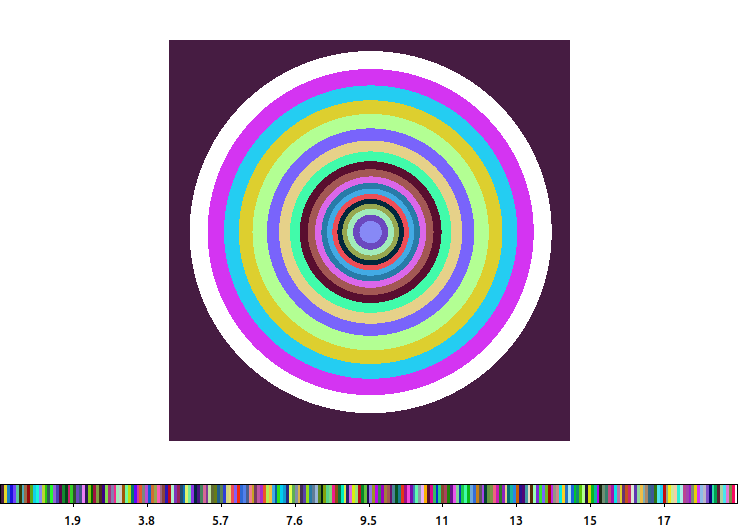

In [7]:
ds9 -linear 7901/ellipse.map -cmap load $ASCDS_CONTRIB/data/005-random.lut \
  -saveimage png ds9_03.png -exit 

display < ds9_03.png

Okay, so we now have an image where each pixel value is the ID number of the region that is extracted.

These are nice integer values.

## Smooth by PSF size

The idea now is to smooth the map with something the size of the PSF.  Obviously the PSF varies across the field (and by energy -- but slowly -- so I'm ignoring that).

The pixels values that remain the nice integer values are far enough from the edge to not be affected by the PSF spill over.

I'm going to be using `dmimgadapt` to do the smoothing.

First make a map of the PSF size.  Two things.

1. I need the psf size in units of logical|image pixel size.  The psfmap created by eg `fluximage` is in arcsec.
2. I need to truncate the pixel values to tenths place.  Why?  `dmimgadapt` scans the input `inradfile` and pre-creates the convolution kernel at each unique pixel value.  If all the pixel values are unique, then it will run out of memory.

In [8]:
mkpsfmap 7901/img.fits 7901/img.psf energy=1.4 spectrum= ecf=0.95 units=logical clob+

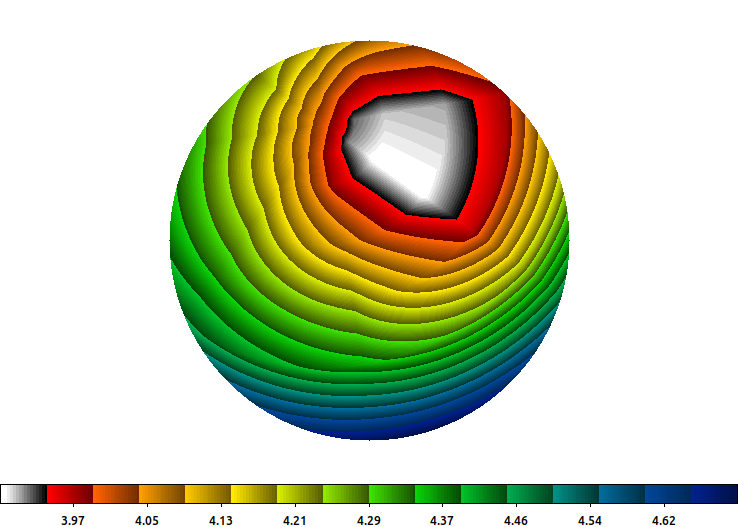

In [9]:
ds9 7901/img.psf -linear -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -saveimage png ds9_04.png -exit 
display < ds9_04.png

Okay,now I'm going to truncte the PSF size value to 1 decminal place.

In [10]:
dmimgcalc 7901/img.psf none 7901/img.psf.0 op=imgout="floor(img1*10.0)/10.0" clob+

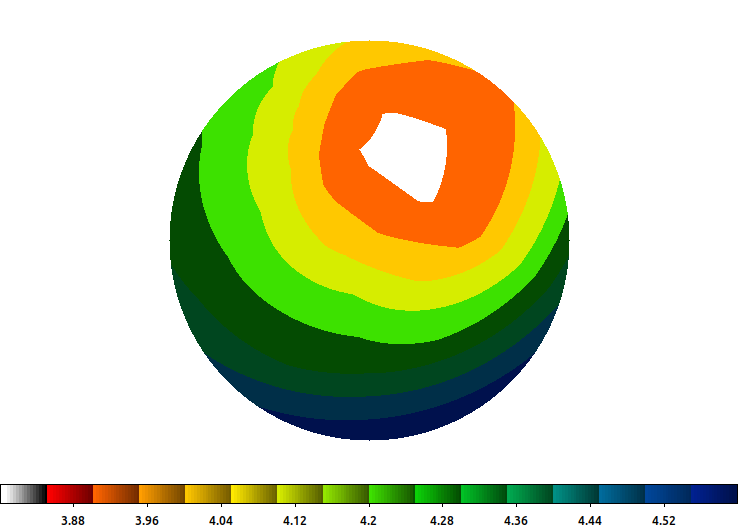

In [11]:
ds9 7901/img.psf.0 -linear -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -saveimage png ds9_05.png -exit 
display < ds9_05.png

Okay now smooth the ellipse ID map with the PSF map.  The `counts` value doesn't matter here -- the value isn't used when the `inradfile` is specified.

In [12]:
dmimgadapt 7901/ellipse.map 7901/psf_overlap.map \
  function=tophat inradfile=7901/img.psf.0 \
  counts=1 mode=h clob+

# dmimgadapt (CIAO 4.13): The following error occurred 35172 times:
(B


> The warning is OK; just telling us that pixles outside the subspace are not being smoothed.

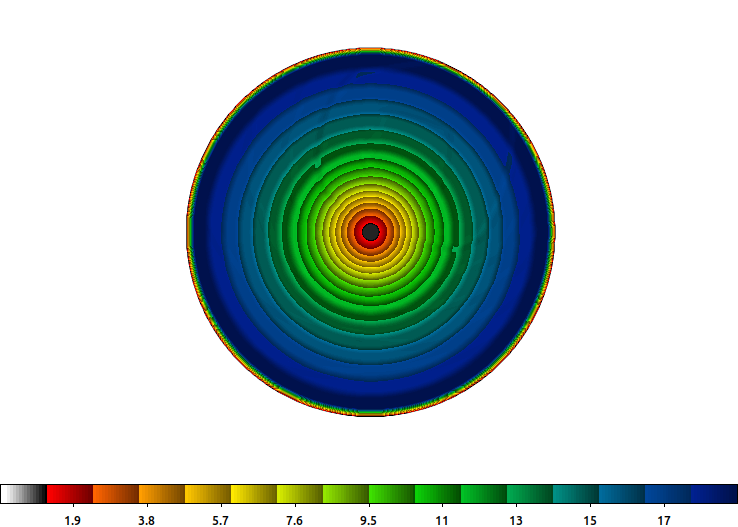

In [13]:
ds9 7901/psf_overlap.map -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -saveimage png ds9_06.png -exit 
display < ds9_06.png

**Great.**

The nice integer pixel values are the pixels that are far enough away from edge to not be influenced by PSF spill over.

The non-integer pixels values have some level of contamination from PSF spill over.

## Take a look at one region

In [14]:
map_id=5

Isolate just the one region ID in the ellipse map. Usees `dmimgthresh` with `cut=a:a value=0` sets everything
except that specific value to `0`.

In [15]:
dmimgthresh 7901/ellipse.map 7901/ellipse.map.${map_id} cut=${map_id}:${map_id} value=0 clob+

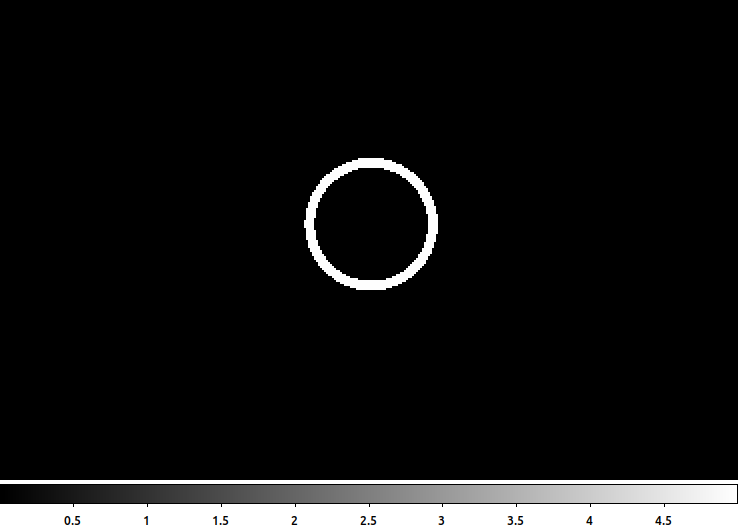

In [16]:
ds9 7901/ellipse.map.${map_id} -zoom to 2 -saveimage ds9_07.${map_id}.png -quit
display < ds9_07.${map_id}.png

Now, remember `mask()` filters from a few years ago ... they can be useful (if used carefully!).

Let's filter the overlap map by the ID map we just created.  The pixel values are, eg 5, which is fine -- any non-zero value is includes.  0/nans are excluded.

In [17]:
dmcopy 7901/psf_overlap.map"[sky=mask(7901/ellipse.map.${map_id})][opt null=nan]" \
  7901/psf_overlap.${map_id}.map clob+

> I'm going to explicitly set the pixels outside the region to NaN.  The mask is in the subspace 
> and dm tools will use it, but it makes it easier to viz. w/ ds9 if they are nan.

In [18]:
dmstat 7901/psf_overlap.${map_id}.map cen-

psf_overlap.map
    min:	4.504268988 	      @:	( 4136 3961 )
    max:	5.5969510723 	      @:	( 4118 4010 )
   mean:	5.0383784843 
  sigma:	0.30952829237 
    sum:	4746.1525322 
   good:	942 
   null:	159859 


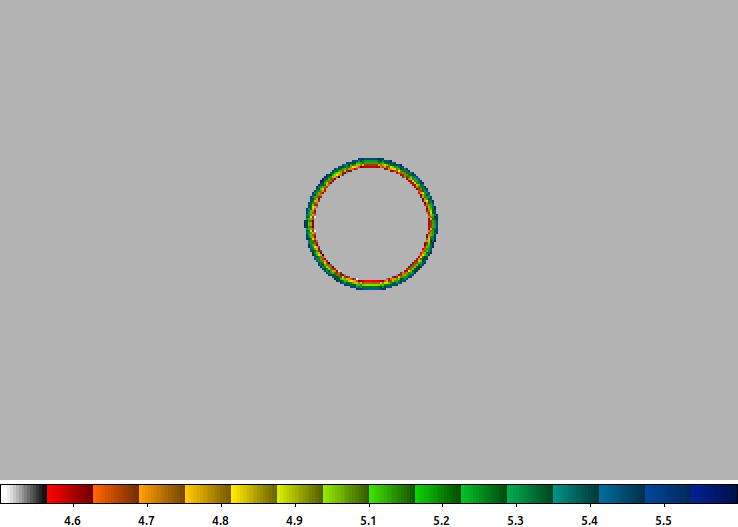

In [19]:
ds9 7901/psf_overlap.${map_id}.map -cmap load $ASCDS_CONTRIB/data/16_ramps.lut \
  -zoom to 2 \
  -scale limits 4.5 5.6 -nan grey70 \
  -saveimage ds9_08.${map_id}.png -quit
display < ds9_08.${map_id}.png

Okay, so we can see that there are spectrum (no pun intended) of pixel values.  The are not the nice integer values that would indicate that they are beyong the PSF spill over.

I can threshold this image the same way to see which pixels are unaffected by PSF spill over.


In [20]:
dmimgthresh 7901/psf_overlap.${map_id}.map 7901/psf_no_overlap.${map_id}.map \
  cut=${map_id}:${map_id} value=0 clob+

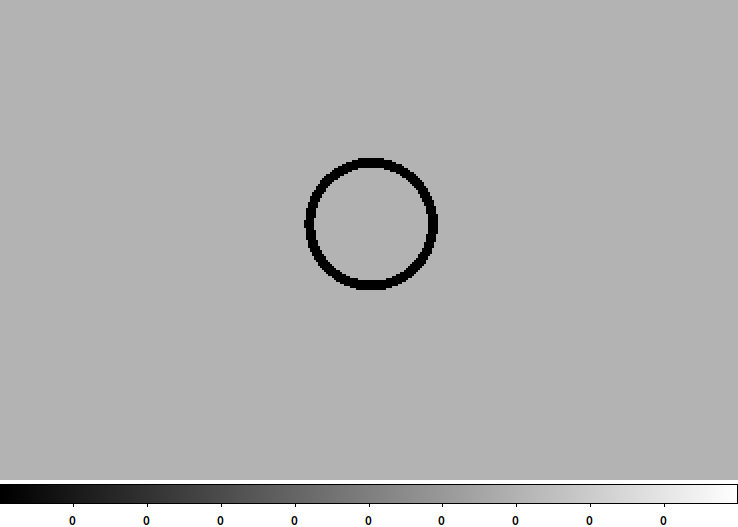

In [21]:
ds9 7901/psf_no_overlap.${map_id}.map \
  -zoom to 2 \
  -nan grey70 \
  -saveimage ds9_09.${map_id}.png -quit
display < ds9_09.${map_id}.png

In [22]:
dmstat 7901/psf_no_overlap.${map_id}.map cen-

psf_overlap.map
    min:	0 	      @:	( 4136 3956 )
    max:	0 	      @:	( 4136 3956 )
   mean:	0 
  sigma:	0 
    sum:	0 
   good:	942 
   null:	159859 


`sum=0` means that there are no pixels in the region are not affected from PSF spillover.


Let's try this again with a larger region's ID.

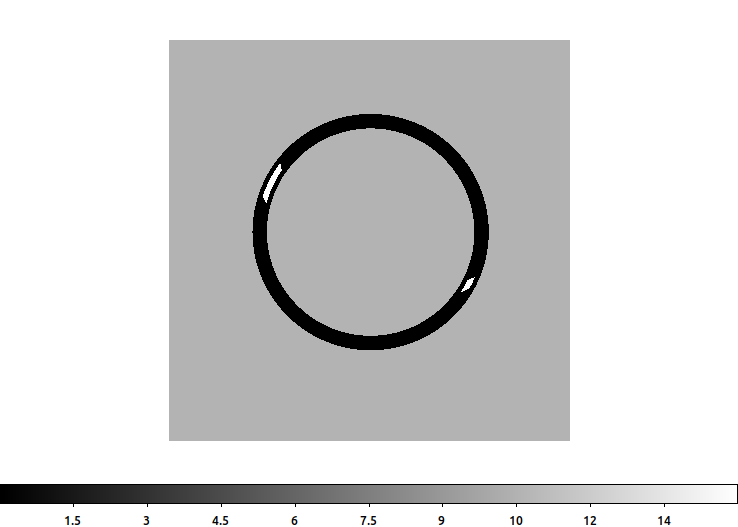

psf_overlap.map
    min:	0 	      @:	( 4130 3871 )
    max:	15 	      @:	( 4234 3929 )
   mean:	0.42580645161 
  sigma:	2.4911414332 
    sum:	4290 
   good:	10075 
   null:	150726 


In [23]:
map_id=15

dmimgthresh 7901/ellipse.map 7901/ellipse.map.${map_id} cut=${map_id}:${map_id} value=0 clob+

dmcopy 7901/psf_overlap.map"[sky=mask(7901/ellipse.map.${map_id})][opt null=nan]" \
  7901/psf_overlap.${map_id}.map clob+

dmimgthresh 7901/psf_overlap.${map_id}.map 7901/psf_no_overlap.${map_id}.map \
  cut=${map_id}:${map_id} value=0 clob+

ds9 7901/psf_no_overlap.${map_id}.map \
  -nan grey70 \
  -saveimage ds9_09.${map_id}.png -quit
display < ds9_09.${map_id}.png


dmstat 7901/psf_no_overlap.${map_id}.map cen-


In [24]:
python -c 'print(3720/15)'

248.0


Okay, so there are `good:10731` pixels in the region.  Out of that, only `248` are unaffected from PSF spillover.

## Quantify 


Rather than just smooth with a `tophat` to get the geometric fraction of overlap, we can use the same technique (maps) to quantify the actual fraction of the PSF that spills over into adjacent bins.


### Approximate w/ Gaussian

First I'm going to split the region map into indivual map files and I'm going to reset the pixel values to `1`.

Along the way I am creating a stack file `ellipse.masks.lis` that I will use to extract the fraction 
of the smoothed map in each bin.


In [25]:
rm -f 7901/ellipse.masks.lis

for map_id in `seq 1 19`
do
    dmimgthresh 7901/ellipse.map - cut=${map_id}:${map_id} value=0 |\
    dmimgthresh - 7901/ellipse.map.${map_id}.unit cut=:0 value=1 cl+
    echo "mask(7901/ellipse.map.${map_id}.unit)" >> 7901/ellipse.masks.lis
done

> piping FITS using "-" is a feature of CFITSIO.  Most of the CIAO tools support it however, the
> scripts (in general) will not since it requires a file be opened only once.

Okay, now to make the Gaussian approximation we need to remake the PSF map with the correct ECF value set to 0.393.  The `dmimgadapt` radii are used as the Gaussian `sigma`.  The 2D ECF value for 1 sigma is 0.393.

In [26]:
mkpsfmap 7901/ellipse.map.1.unit \
  7901/one_sigma.psf energy=1.4 spectrum= ecf=0.393 units=logical clob+

dmimgcalc 7901/one_sigma.psf none 7901/one_sigma.psf.clip op="imgout=floor(img1*20.0)/20.0" clob+

#ds9 7901/one_sigma.psf.clip 


Okay, now we will run `dmimgadapt` as before.  

But, I want to normalize the map file so that the sum of the pixel values is == 1.0. Just use `dmstat` and `dmimgcalc`.

In [27]:
for map_id in `seq 1 19`
do
    dmstat 7901/ellipse.map.${map_id}.unit cen- verb=0
    tot=$(pget dmstat out_sum)

    dmimgcalc 7901/ellipse.map.${map_id}.unit none - \
      op="imgout=((float)img1)/${tot}" | \
    dmimgadapt - \
      7901/gauss.${map_id}.map \
      function=gaus inradfile=7901/one_sigma.psf.clip \
      counts=1 mode=h clob+ > /dev/null 2>&1
done


The idea here is to smooth the map, and then extract the radial profile in each of the bins to see how much of the map is counted in each bin.

In [28]:
punlearn dmextract

for map_id in `seq 1 19`
do
    dmextract "7901/gauss.${map_id}.map[bin (x,y)=@-7901/ellipse.masks.lis]" \
      out=gaus_go_${map_id}.fits  op=generic mode=h clob+ 
done

> The `@-` syntax tells the stack expansion to **not** append the path name onto the 
> elements in the stack.

I now have the radial profile for each grid in a separate file; let's put them all together into one.

In [29]:
rm rename.lis
touch rename.lis
for map_id in `seq 1 19`
do
  echo gaus_go_${map_id}.fits"[cols map${map_id}=counts]" >> rename.lis
done


dmpaste gaus_go_1.fits"[cols component]" @-rename.lis matrix.fits clob+

[1] 16465
[1]+  Done                    ds9 -title delme -prism matrix.fits


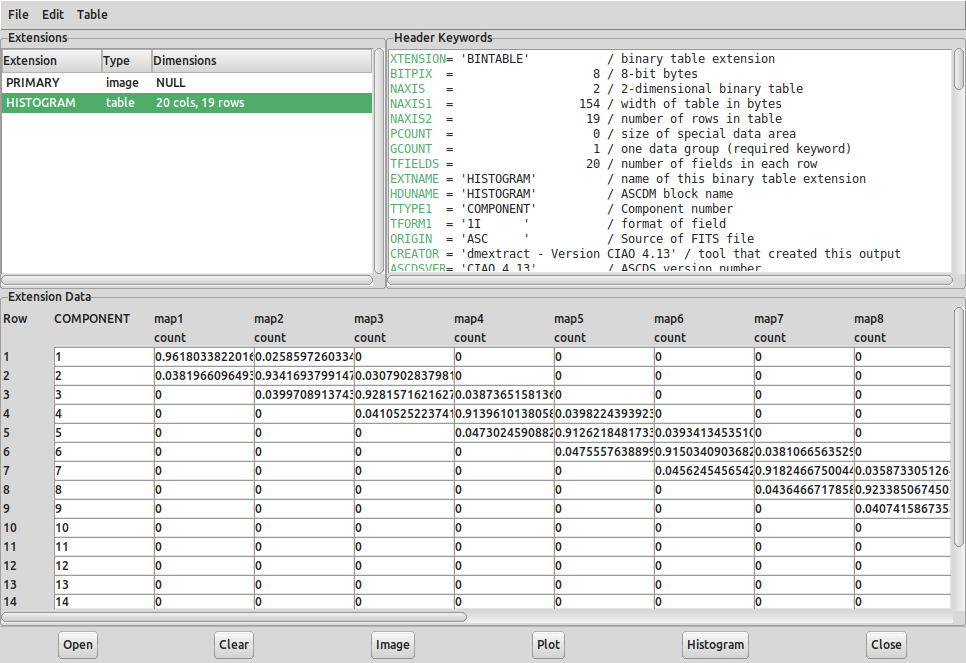

In [30]:
ds9 -title delme -prism matrix.fits &
sleep 5
import -window "Prism" prism.png
xpaset -p delme quit

display < prism.png

Finally, turn table into an image via DM ascii hackery 

In [31]:
## Make an ASCII image the same size as we need so we can steal the header (everything above the END keyword)
echo 1 1 > a
dmcopy a"[bin col1=1:20:1,col2=1:20:1][opt type=r4]" img.dat"[opt kernel=text/dtf]" cl+ 

cat img.dat | egrep "^END" --before-context=100 > img.hdr

## Add blank line after END
echo "" >> img.hdr

## Now list the values in the table, this is the image body
dmlist matrix.fits"[cols -component]" data,clean   | egrep -v "^#" > img.body

## Combine them
cat img.hdr img.body > matrix.dat

## Make into FITS
dmcopy matrix.dat matrix.img clob+

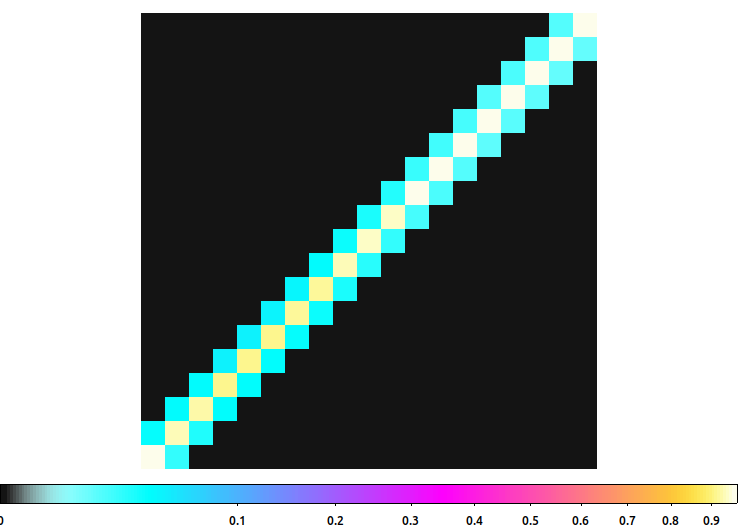

In [32]:
ds9 matrix.img -scale sqrt -zoom to 24 \
  -cmap load $ASCDS_CONTRIB/data/cold.lut \
  -colorbar space value \
  -saveimage png ds9_11.png -exit \

display < ds9_11.png 

This is the radial profile equivalent of the RMF.

It gives us an approximation of the flux in each bin which spill over into adjacent bins.

You can supply `mkpsfmap` a spectrum instead of a monochromatic energy; and a different spectrum for each grid if desired.


## With MARX

**Unexpected OFFSET in marx simulation**


I know that `marx` also allows users to input an image.  That would be an even better way to compute the PSF fraction in each adjacent bin.

Below is a rough outline; but I'm getting an unexpected shift in the MARX output so the actual results are not correct.


I'll start by simulating just a point source using `simulate_psf` with `keep=yes` so it will save the `marx.par` parameter file.

In [33]:
punlearn dmcoords
dmcoords 7901/repro/acisf07901_repro_evt2.fits op=sky x=4096 y=4096 verb=0 celfmt=deg
ra=$(pget dmcoords ra)
dec=$(pget dmcoords dec)

In [34]:
dmlist 7901/repro/acisf07901_repro_evt2.fits header,clean | grep PNT

RA_PNT                     195.9342361087 [deg]     Pointing RA
DEC_PNT                    -24.2295572266 [deg]     Pointing Dec
ROLL_PNT                    80.7217462675 [deg]     Pointing Roll


In [35]:
punlearn simulate_psf
simulate_psf in=7901/repro/acisf07901_repro_evt2.fits \
  out=delme ra=${ra} dec=${dec} \
  spectrum= mono=1 flux=1e-4 \
  keep+ 

simulate_psf
          infile = 7901/repro/acisf07901_repro_evt2.fits
         outroot = delme
              ra = 195.9343110431267
             dec = -24.22962555989299
    spectrumfile = 
      monoenergy = 1
            flux = 0.0001
       simulator = marx
         rayfile = 
       projector = marx
     random_seed = -1
            blur = 0.07000000000000001
  readout_streak = no
          pileup = no
           ideal = yes
        extended = yes
         binsize = 1
          numsig = 7
         minsize = INDEF
         numiter = 1
        keepiter = yes
        asolfile = 
       marx_root = /soft/ciao-4.13/marx-5.5.1
         verbose = 1
            mode = ql

Started check_setup
Finished check_setup
Performing iteration 1 of 1
Started run_marx
Finished run_marx
Started create_psf_image
Finished create_psf_image
Started create_average_image
Finished create_average_image

Final output PSF image is : delme.psf[PSF]


Okay, now like before, split the region map into individual files.


But MARX says

> This option creates photons distributed on the sky according to an input image. The probability that a ray starts at a given position is proportional to the pixel value at this point. Within a pixel, the position is randomized. marx inspects the header of the file for a WCS specification and extracts the pixel scale. However, it does not extract the position or orientation on the sky. **marx will just assume that the image is centered on the optical axis and that the axes directions are aligned with the detector axes.**

so I need to reproject the map so that the center of the image is the optical axis (`PNT` values)

In [36]:
rm -f 7901/ellipse.masks.lis

for map_id in `seq 1 19`
do
    dmimgthresh 7901/ellipse.map - cut=${map_id}:${map_id} value=0 |\
    dmimgthresh - - cut=:0 value=1 | \
    reproject_image_grid \
      in=- \
      out=7901/ellipse.map.${map_id}.unit \
      xsize=2048 ysize=2048\
      xcen=${ra} ycen=${dec} \
      theta=0 pixelsize=0.0001366666667 \
      projection=tan res=0 method=sum \
      coord=world mode=h clob+

      echo "mask(7901/ellipse.map.${map_id}.unit)" >> 7901/ellipse.masks.lis
done

I might want to redo `mkregmap` instead of `reproject_image_grid` here.  I'm using 
`res=0` to set the resolution=0, so that only the center of the pixel is reprojected which 
should any kind of situation where same pixel get counted more than once.

I now run `marx` and `marx2fits`.

The marx output is binned into an image the same size as the map file, and normalized so that the
sum of the pixels <= 1.0.

In [37]:

for map_id in `seq 1 19`
do

    cp delme_i0000_marx.par marx_${map_id}.par 
    pset ./marx_${map_id}.par  \
      SourceType=IMAGE \
      S-ImageFile=7901/ellipse.map.${map_id}.unit \
      OutputDir=7901/${map_id}/marx \
      SourceFlux=1.0e-2

    mkdir -p 7901/${map_id}/marx/

    marx @@marx_${map_id}.par

    marx2fits 7901/${map_id}/marx 7901/${map_id}/psf.evt.fits > /dev/null 2>&1 

    get_sky_limits 7901/ellipse.map.${map_id}.unit > /dev/null 2>&1 
    bin=$(pget get_sky_limits dmfilter)
    cts=$(dmlist 7901/${map_id}/psf.evt.fits counts)

    dmimgcalc 7901/${map_id}/psf.evt.fits"[bin ${bin}][opt type=r4]" \
      none 7901/${map_id}/psf.img.fits \
      op=imgout="img1/$cts" clob+

done

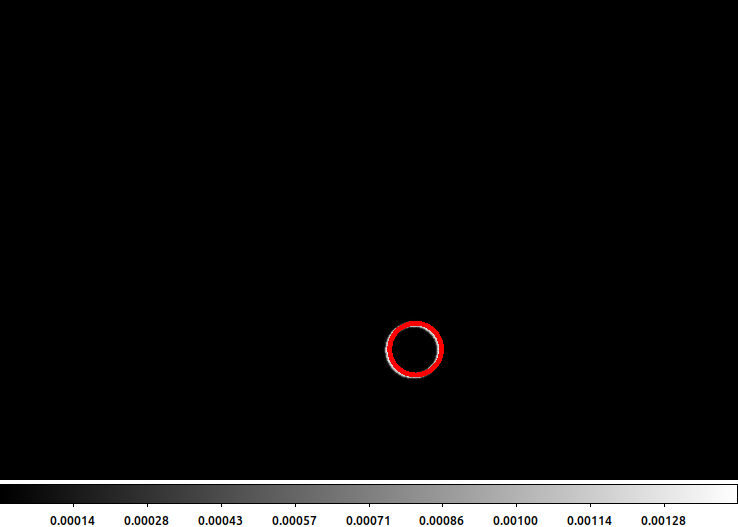

In [38]:
map_id=4 
ds9 7901/${map_id}/psf.img.fits \
  -mask 7901/ellipse.map.${map_id}.unit \
  -saveimage png ds9_13.png -quit

display < ds9_13.png

> Unfortuantely, there looks to be a shift between the input image and the MARX simulation. This will 
> mess up the results, but we'll just keep going for now.

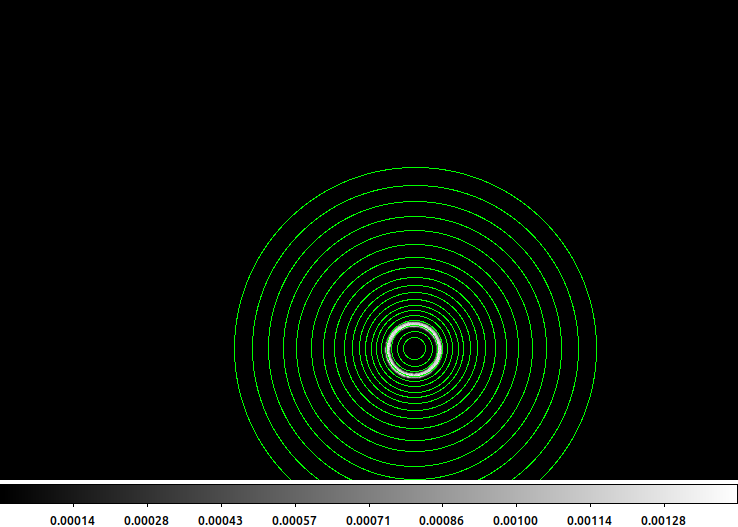

In [39]:
map_id=4
ds9 7901/${map_id}/psf.img.fits -region 7901/ellipse.reg \
  -saveimage png ds9_10.png -exit

display < ds9_10.png

> As before, we can see that the simulation doesn't match the regions.


Now as before, we extract the radial profile in each grid

In [40]:
punlearn dmextract

for map_id in `seq 1 19`
do
    dmextract "7901/${map_id}/psf.img.fits[bin (x,y)=@-7901/ellipse.masks.lis]" \
      out=go_go_${map_id}.fits  op=generic mode=h clob+ 
done

and combine into 1 file

In [41]:
rm rename.lis
touch rename.lis
for map_id in `seq 1 19`
do
  echo go_go_${map_id}.fits"[cols map${map_id}=counts]" >> rename.lis
done


dmpaste go_go_1.fits"[cols component]" @-rename.lis matrix.fits clob+

In [42]:
### ds9 -prism matrix.fits

and make into an image

In [43]:
# Turn table into an image via DM ascii hackery 

## Make an image the same size as we need so we can steal the header (everything above the END keyword)
echo 1 1 > a
dmcopy a"[bin col1=1:20:1,col2=1:20:1][opt type=r4]" img.dat"[opt kernel=text/dtf]" cl+ 

cat img.dat | egrep "^END" --before-context=100 > img.hdr

## Add blank line after END
echo "" >> img.hdr

## Now list the values in the table, this is the image body
dmlist matrix.fits"[cols -component]" data,clean   | egrep -v "^#" > img.body

## Combine them
cat img.hdr img.body > matrix.dat

## Make into FITS
dmcopy matrix.dat matrix.img clob+

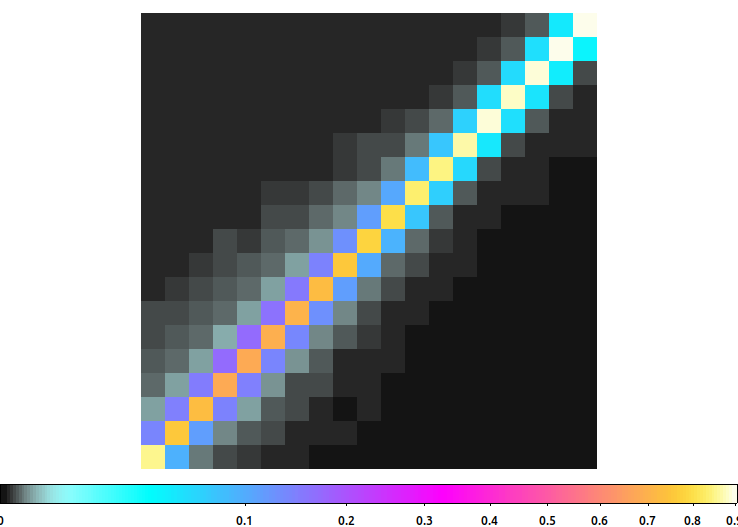

In [44]:
ds9 matrix.img -scale sqrt -zoom to 24 \
  -cmap load $ASCDS_CONTRIB/data/cold.lut \
  -colorbar space value \
  -saveimage png ds9_11.png -exit \

display < ds9_11.png 

The overall shape (diagonal) looks good and the fact that we're spreading into multiple adjacent bins is expected; but due to the shift the actual values here are not correct.